# Arize AX Observability + LangChain Simple Agent (Demo)

This notebook shows how to:
1. Instrument a LangChain (or LangGraph) agent using **OpenInference** (OpenTelemetry-compatible tracing).
2. Send traces to **Arize AX (cloud)** so you can inspect:
   - LLM calls (prompts, responses, tokens, latency)
   - Tool calls (inputs/outputs)
   - Agent reasoning loop
3. View traces inside Arize AX under your Space.

**Why this matters:** When agents get complex (tools, RAG, multi-turn), tracing is the fastest way to debug failures, latency spikes, hallucinations, and tool misuse.


## 0. Install Dependencies

We need four groups of packages:

1. **LangChain / tools / model wrappers**  
2. **OpenTelemetry (OTEL)**: tracing standard used by Arize  
3. **OpenInference instrumentation**: auto-creates spans for LangChain calls  
4. **Arize OTEL exporter**: ships traces to Arize cloud


In [1]:
!pip -q install \
  arize-otel \
  openinference-instrumentation-langchain \
  langchain langchain-openai langchain-community \
  opentelemetry-sdk opentelemetry-exporter-otlp


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


## 1. Configure Keys

You need:
- **OPENAI_API_KEY** (or your LLM provider’s key)
- **ARIZE_SPACE_ID** and **ARIZE_API_KEY** from Arize AX:
  - Go to your Space → Settings → API Keys
- **ARIZE_PROJECT_NAME** (this becomes the filter name in Traces UI)

These are stored as env vars so Arize + OTEL can read them automatically.


In [4]:
import os

# LLM key
os.environ["OPENAI_API_KEY"] = "sk-OPENAI_API_KEY"

# Arize AX auth
os.environ["ARIZE_SPACE_ID"] = "YOUR_SPACE_ID"
os.environ["ARIZE_API_KEY"] = "ak-ARIZE_API_KEY"

# Project name shown in Arize Traces UI
os.environ["ARIZE_PROJECT_NAME"] = "langchain-agent-demo" # ANY SUITABLE NAME


## 2. Register the Arize OpenTelemetry Exporter

Arize provides a helper `register()` that:
- creates an OTEL TracerProvider
- attaches an OTLP exporter
- points it at Arize AX

Everything traced after this will flow into your Space.


In [5]:
from arize.otel import register

tracer_provider = register(
    space_id=os.getenv("ARIZE_SPACE_ID"),
    api_key=os.getenv("ARIZE_API_KEY"),
    project_name=os.getenv("ARIZE_PROJECT_NAME"),
)


🔭 OpenTelemetry Tracing Details 🔭
|  Arize Project: langchain-agent-demo
|  Span Processor: BatchSpanProcessor
|  Collector Endpoint: otlp.arize.com
|  Transport: gRPC
|  Transport Headers: {'authorization': '****', 'api_key': '****', 'arize-space-id': '****', 'space_id': '****', 'arize-interface': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



## 3. Turn on Auto-Instrumentation for LangChain

OpenInference provides `LangChainInstrumentor`, which:
- hooks into LangChain callbacks
- emits OTEL spans for:
  - model calls
  - tool calls
  - agent loops
  - retrievers/vectorstores (if present)

⚠️ Important: instrumentation must happen **before creating or running your agent**.


In [6]:
from openinference.instrumentation.langchain import LangChainInstrumentor

LangChainInstrumentor().instrument(tracer_provider=tracer_provider)


## 4. Build a simple LangChain agent (2 tools)

In [14]:
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent
from langchain_core.tools import tool

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

@tool
def multiply(a: float, b: float) -> float:
    """Multiply two numbers."""
    return a * b

@tool
def add(a: float, b: float) -> float:
    """Add two numbers."""
    return a + b

tools = [multiply, add]

agent = create_agent(
    model=llm,
    tools=tools,
    system_prompt="You are a helpful assistant. Use tools when needed."
)

out = agent.invoke({"input": "Multiply 12 by 7 then add 5."})
out


{'messages': [AIMessage(content='How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 72, 'total_tokens': 80, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_11f3029f6b', 'id': 'chatcmpl-Ckvti82kWUfnuz04wTm1EbZhXXqb3', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b042d-fff8-7860-a08b-e11fc329b632-0', usage_metadata={'input_tokens': 72, 'output_tokens': 8, 'total_tokens': 80, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

## 5. Run the Agent (Traces will appear in Arize)

When you invoke:
- Arize will receive a **trace**
- inside it, you’ll see spans for:
  - Agent decision step(s)
  - Tool calls (+ arguments, outputs)
  - LLM prompt/response

Open Arize → Observe → Traces → filter by project name.


In [16]:
question = "If I buy 3 items at $19.99 each and use a $10 coupon, what do I pay?"
result = agent.invoke({"input": question})
result


{'messages': [AIMessage(content='How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 72, 'total_tokens': 80, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_aa07c96156', 'id': 'chatcmpl-Ckvu6U3rbUmxzcC2tGsGkG6wTSZIj', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b042e-5d6b-7181-bce7-181c78b48ae1-0', usage_metadata={'input_tokens': 72, 'output_tokens': 8, 'total_tokens': 80, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

## Optional: Add Metadata for Better Filtering

Metadata becomes searchable in Arize (super useful in production).

Examples:
- user id
- session id / thread id
- app version
- environment (dev/staging/prod)


In [18]:
from opentelemetry import trace

tracer = trace.get_tracer(__name__)

with tracer.start_as_current_span("user_request") as span:
    span.set_attribute("user.id", "demo-user-001")
    span.set_attribute("app.version", "0.1.0")
    out = agent.invoke({"input": "Multiply 12 by 7 then add 5."})

out


{'messages': [AIMessage(content='How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 72, 'total_tokens': 80, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_aa07c96156', 'id': 'chatcmpl-CkvuLZxfZ5K9ciBWqZdqLXupNWAy9', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b042e-97e4-7851-8dba-53d3abcbdc80-0', usage_metadata={'input_tokens': 72, 'output_tokens': 8, 'total_tokens': 80, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

## Notes / Best Practices

1. **Instrument first, then create the agent.**  
   Otherwise spans won’t be captured.

2. **Use toy tools first.**  
   It makes it obvious in Arize whether the agent is reasoning correctly.

3. **When scaling to RAG:**  
   Arize will automatically trace:
   - retriever spans
   - embedding spans
   - vector DB calls
   as long as those components are LangChain-based.

4. **LangGraph support:**  
   OpenInference `LangChainInstrumentor` also traces LangGraph agents, so the setup stays consistent.


## Viewing Traces in Arize AX

Go to your Arize Space:

**Observe → Traces** (sometimes labeled “LLM Tracing”)

Filter:
- `project_name = langchain-agent-demo`

You should see:
- One trace per `agent.invoke`
- Each trace contains multiple spans:
  - **Agent**
  - **LLM call(s)**
  - **Tool call(s)**

Click a trace → you can inspect:
- prompt text
- response text
- tool inputs/outputs
- latency breakdown
- errors (if any)


---

**As shown in below screenshots**


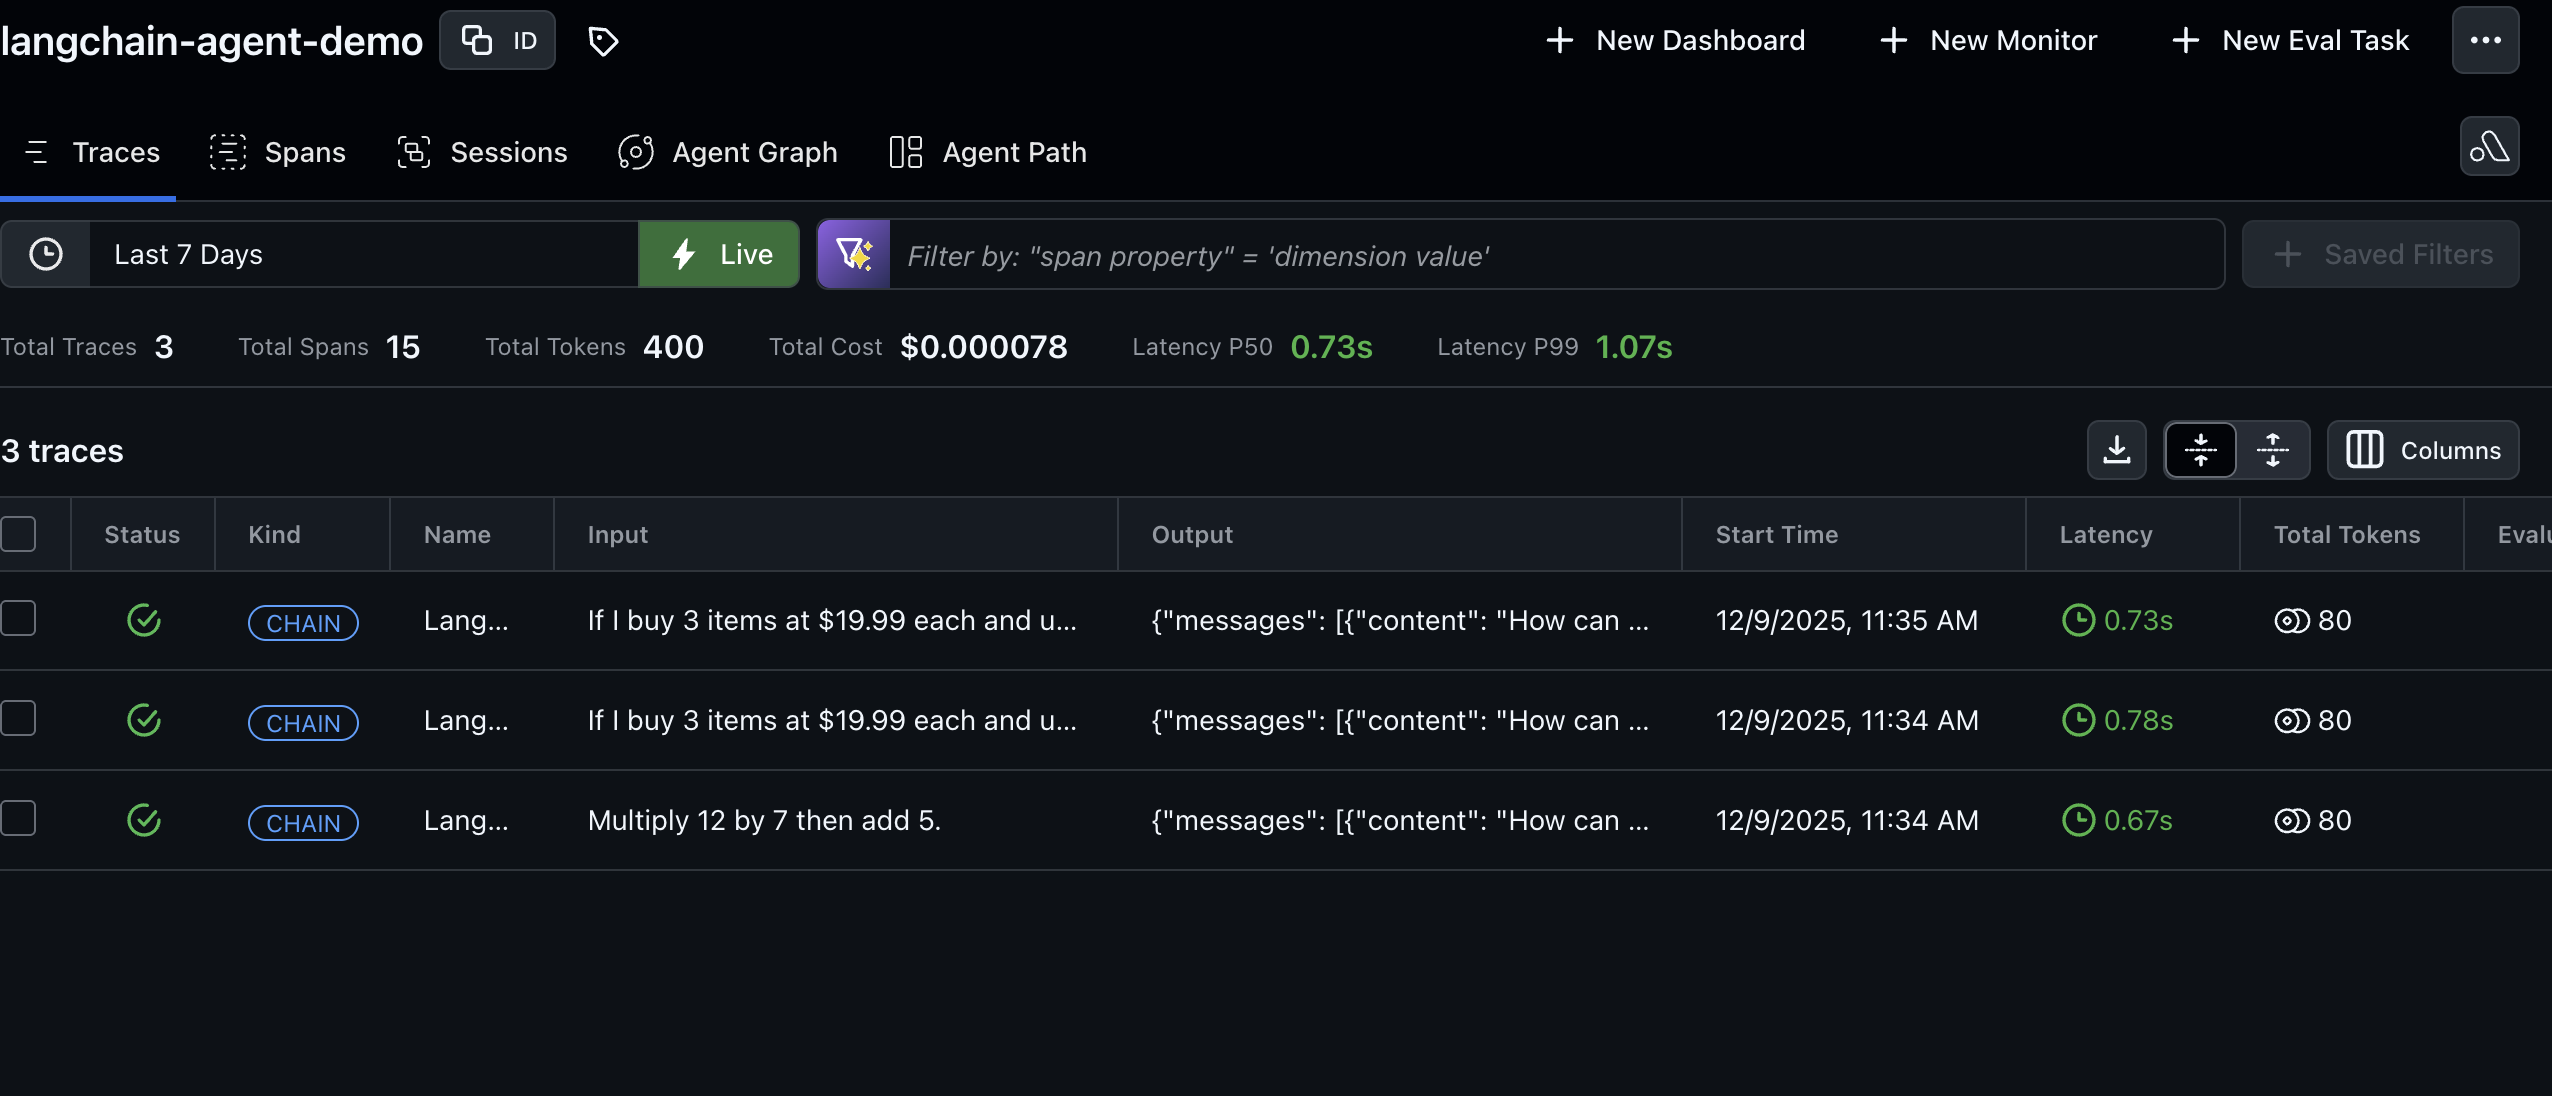

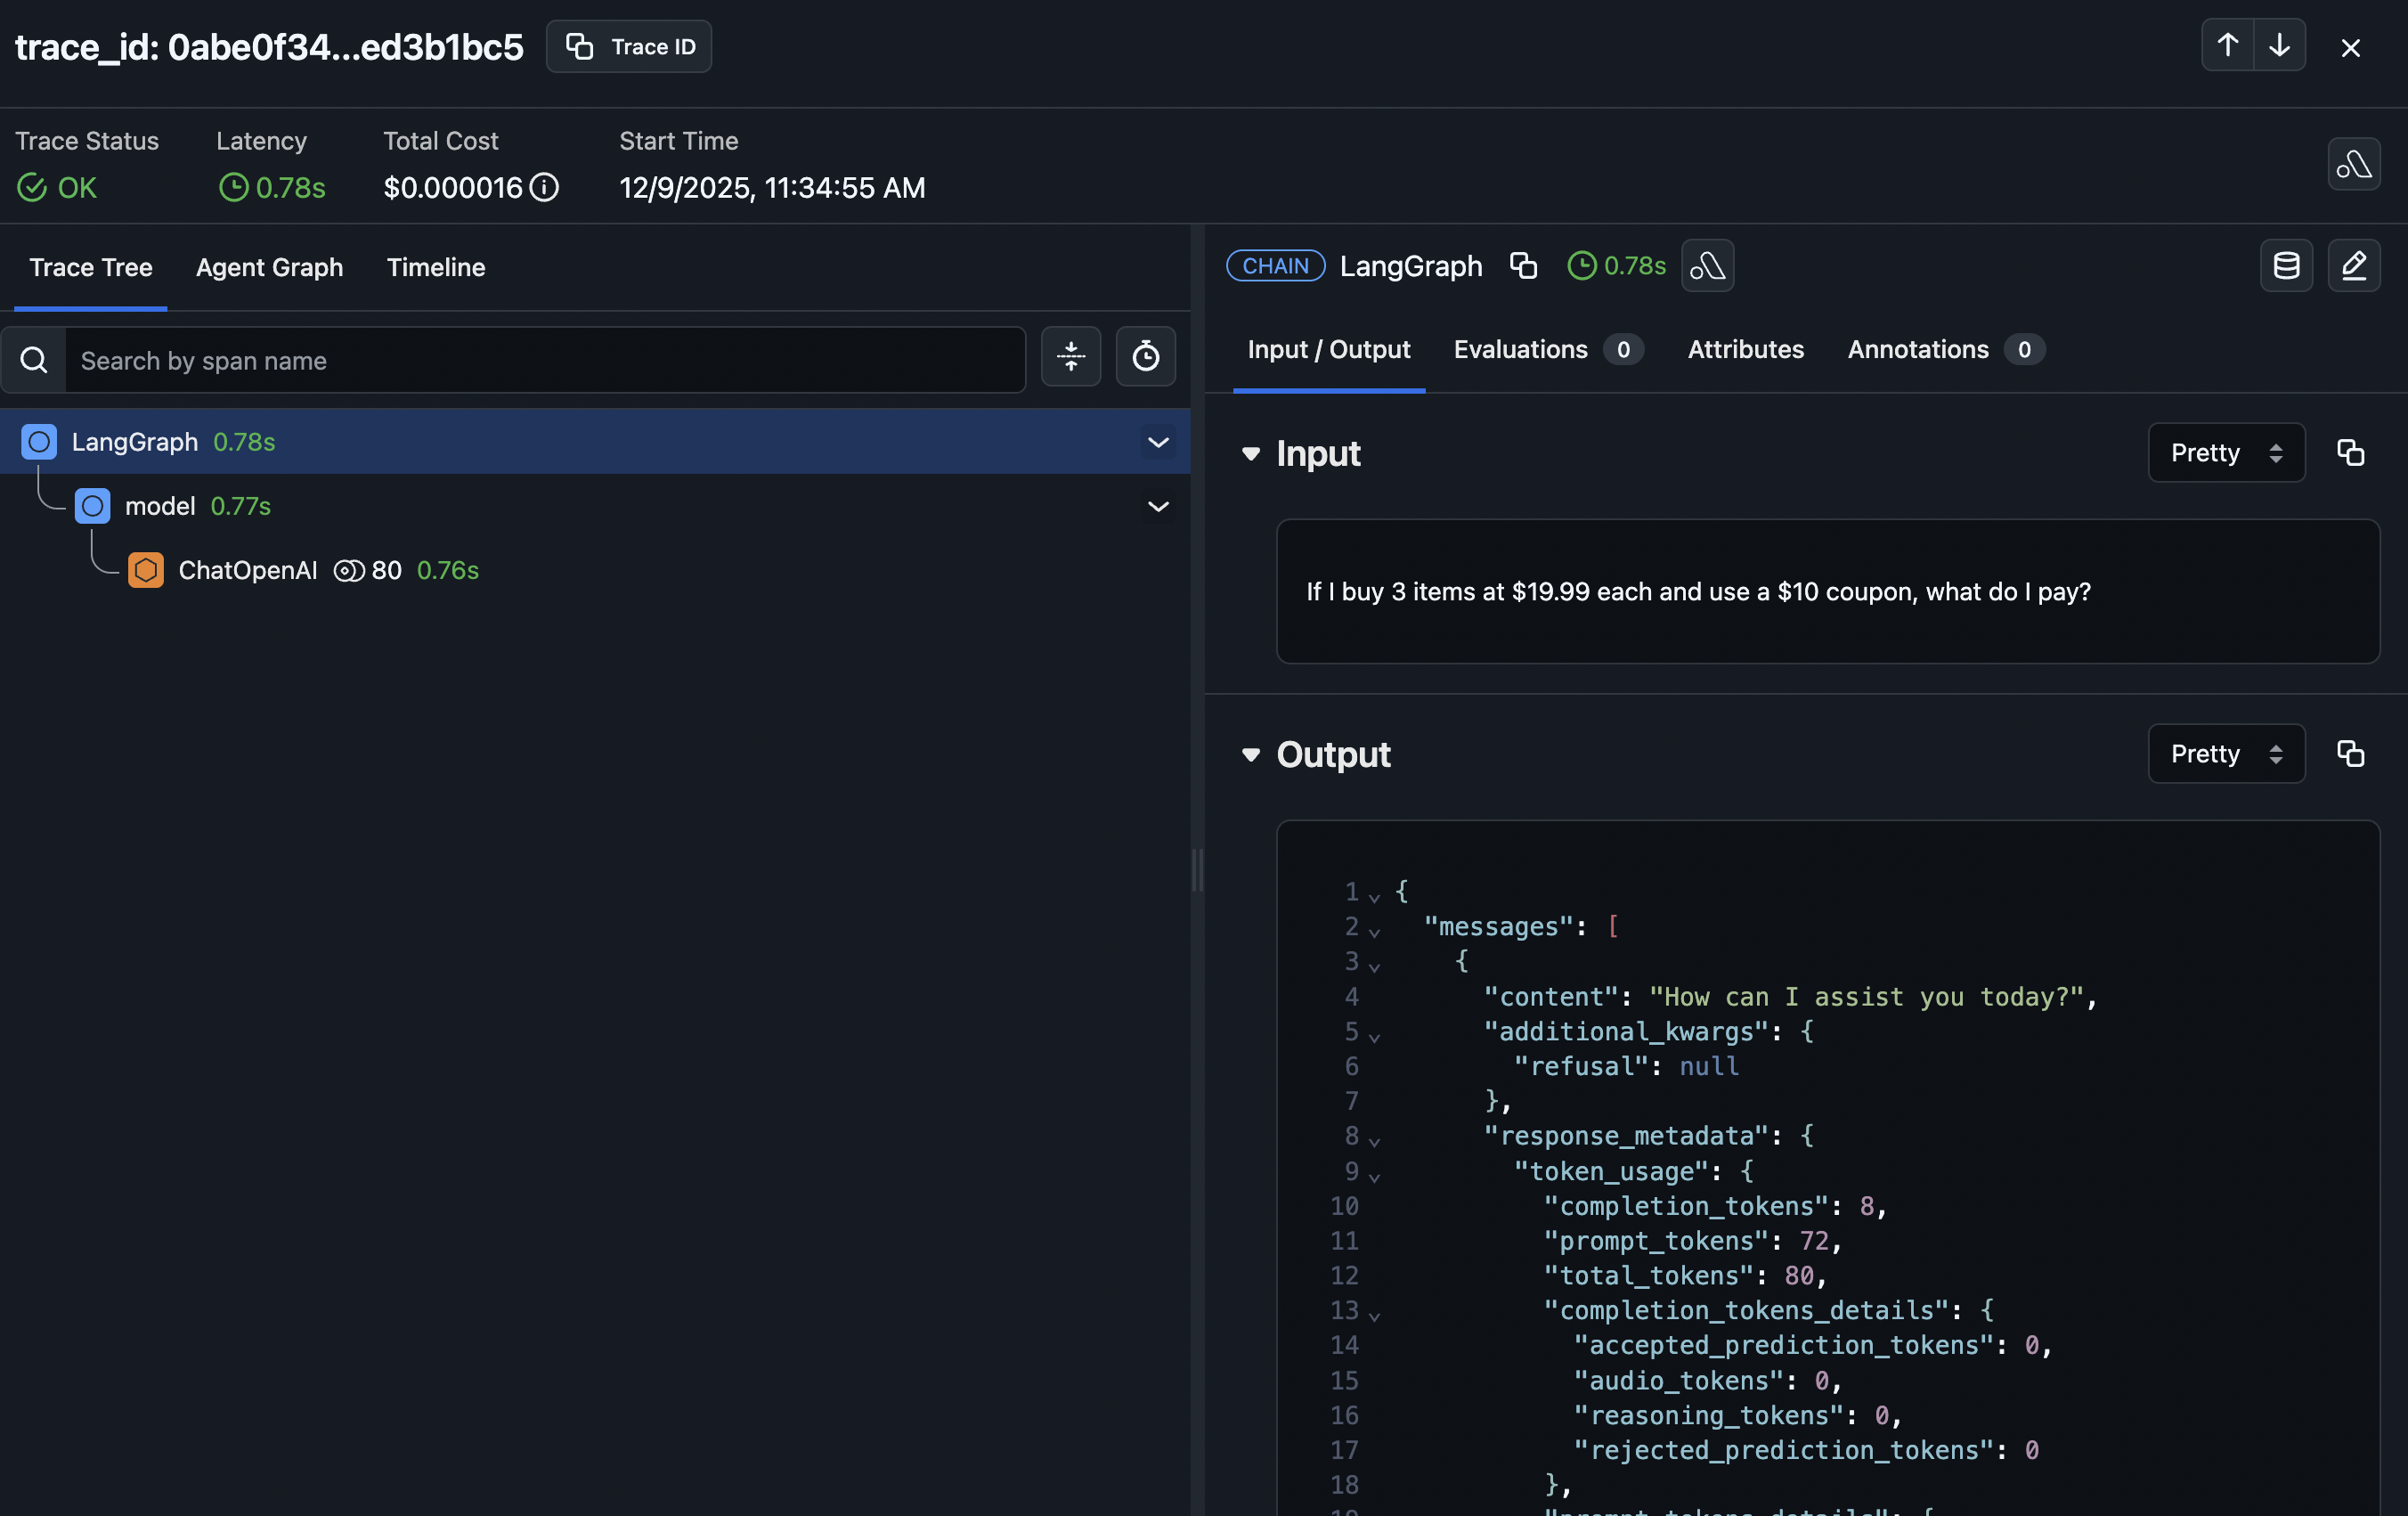

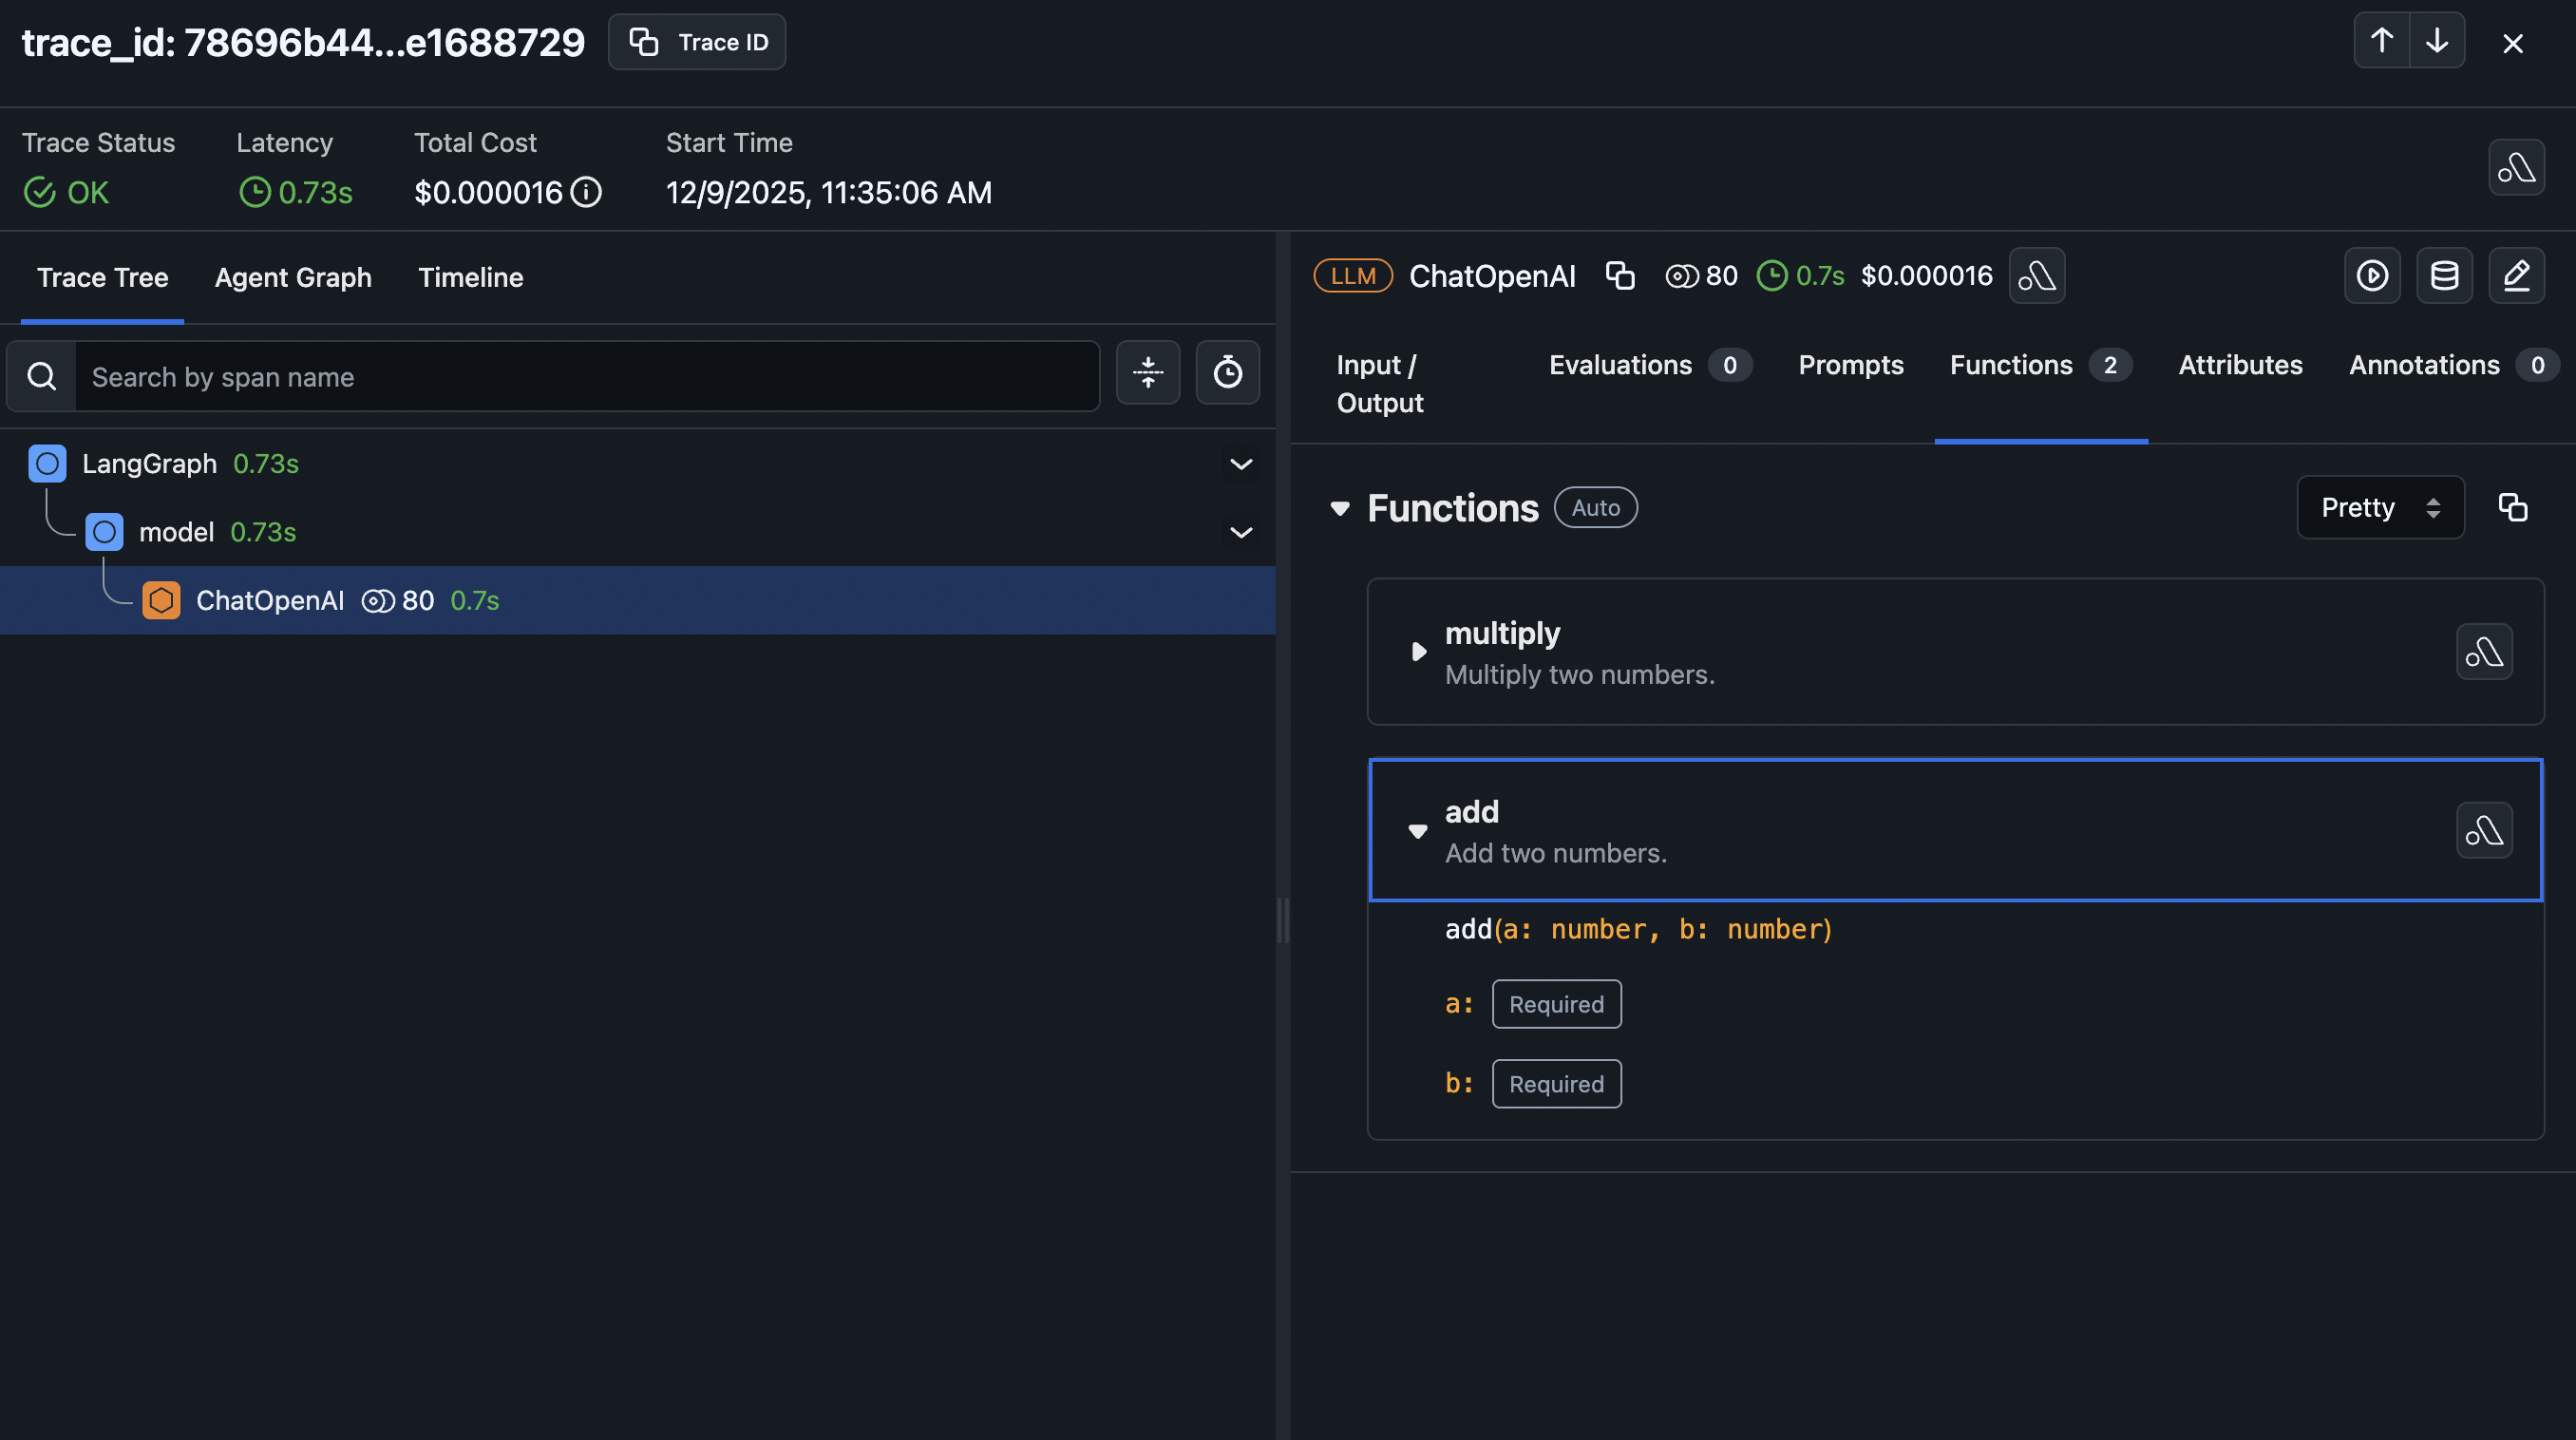